# Setup

In [1]:
# Impot modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Create/Map directories
if not os.path.exists('figure'): os.mkdir('figure')
if not os.path.exists('result'): os.mkdir('result')
data_path = os.path.join(os.getcwd(), "data")
figure_path = os.path.join(os.getcwd(), "figure")
result_path = os.path.join(os.getcwd(), "result")

# Import

In [3]:
sheet_to_df_map = pd.read_excel(os.path.join(data_path, "full.xlsx"), sheet_name=None)
full = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

recategorised_data = pd.read_csv(os.path.join(data_path, "recategorised_data.csv"))

# Tidy

In [4]:
full.dropna()
full["Class"] = np.where(full["Entero"]>=280, 1, 0)
full = full.drop(["Entero"], axis=1)

recategorised_data = recategorised_data.drop(["Entero", "RainWA", "BeachName", "Wspeed", "Wdirection", "BeachDirection"], axis=1)
recategorised_data["DATE"]=recategorised_data["DATE"].astype("datetime64")
recategorised_data = recategorised_data.reindex(columns=(list([c for c in recategorised_data.columns if c != "Entero_level"]) + ["Entero_level"]))

# Exploration

In [5]:
# Raw data
full

,Date,Rain24,Rain48,Rain72,RainWA,WDirection,WSpeed,SolarHours,Class
0,1995-12-16,9.17,13.67,37.00,59.84,200,1.5,1.8,0
1,1995-12-27,0.00,0.00,0.33,0.33,230,5.7,8.5,0
2,1995-12-28,2.50,2.50,2.50,7.50,320,3.6,11.7,0
3,1996-01-07,0.00,0.00,0.00,0.00,130,4.1,7.9,0
4,1996-01-08,0.00,0.00,0.00,0.00,100,3.6,4.4,0
...,...,...,...,...,...,...,...,...,...
2014,2017-08-18,1.50,1.50,1.50,4.50,172,1.7,1.6,0
2015,2017-08-28,6.50,8.00,8.00,22.50,5,4.1,3.7,0
2016,2017-09-14,0.00,1.00,4.00,5.00,261,3.1,2.8,0
2017,2017-09-18,26.00,26.50,34.00,86.50,276,2.8,6.1,0


In [6]:
# Stats
figure = full.describe()
figure.to_csv(os.path.join(figure_path, "stats.csv"))

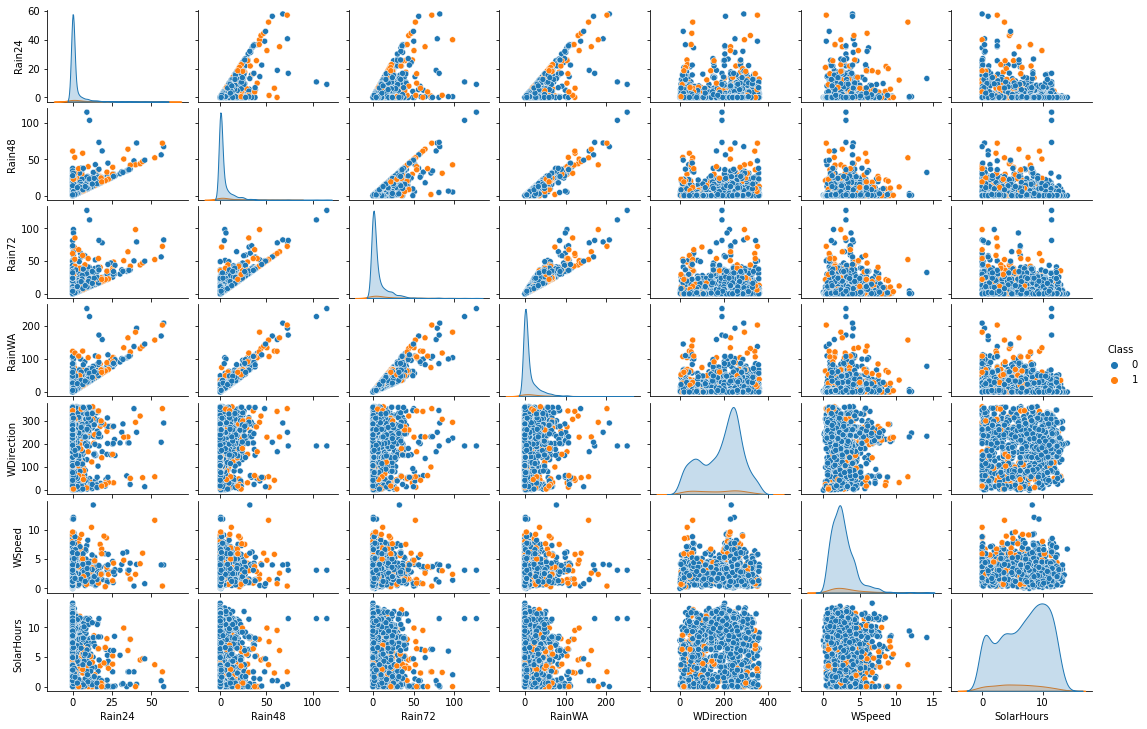

In [7]:
# Scatter plots
figure = sns.pairplot(full, hue="Class").figure
figure.set_size_inches(16, 10)
figure.savefig(os.path.join(figure_path, "scatter_plots"), bbox_inches="tight")

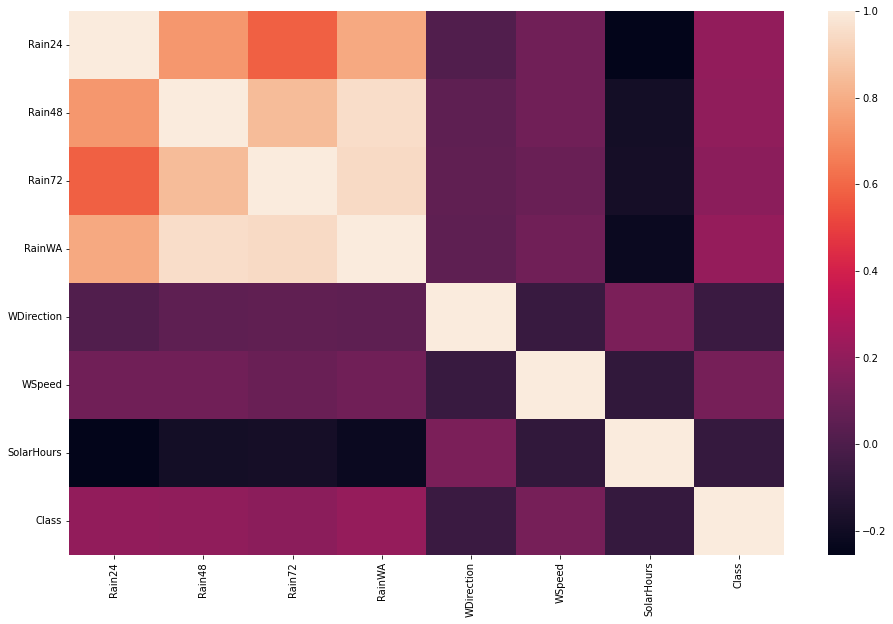

In [8]:
# Correlation heatmap
figure = sns.heatmap(full.corr()).get_figure()
figure.set_size_inches(16, 10)
figure.savefig(os.path.join(figure_path, "correlation_heatmap"), bbox_inches="tight")

# Modelling

## Helpers

In [9]:
# Set random state
RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

# Order data by date
recategorised_data = recategorised_data.sort_values(by=['DATE'])
recategorised_data.drop("DATE", axis=1)

# Extract features and label
def extract(dataframe):
    X = np.array(dataframe.iloc[:, 1:-1])
    y = np.array(dataframe.iloc[:, -1])
    return X, y

# Timeseries split, the test size can be calculated by count/(split+1)
ts = TimeSeriesSplit(n_splits=5, test_size=336)

# Cross-validation split 
kf = KFold(n_splits=4)

In [10]:
def rolling_cv(hyperparameters, setup_classifier):
    # Pre-allocate space for results
    cv = np.zeros((ts.n_splits, kf.n_splits, len(hyperparameters)))

    # Multi-split the data into train sets and test sets in a timely manner
    ts_idx = -1
    for train_index, test_index in ts.split(recategorised_data):    
        ts_idx += 1
        train, test = recategorised_data.iloc[train_index, :], recategorised_data.iloc[test_index, :]

        # Cross-validate train sets
        kf_idx = -1
        for train_index, validation_index in kf.split(train):
            kf_idx += 1
            X_train, y_train = extract(train.iloc[train_index, :])
            X_valdn, y_valdn = extract(train.iloc[validation_index, :])

            # Fit the scaler to X_train, and then use it to transform both the train set and the test set
            transfromer = preprocessing.Normalizer().fit(X_train[:, 0:3])
            X_train[:, 0:3] = transfromer.transform(X_train[:, 0:3])
            X_valdn[:, 0:3] = transfromer.transform(X_valdn[:, 0:3])

            # Oversample the train set with ADASYN
            adasyn = ADASYN(sampling_strategy="minority", n_neighbors=1)
            X_train, y_train = adasyn.fit_resample(X_train, y_train)

            # Test hyperparameters
            idx = -1
            for i in hyperparameters:
                idx += 1
                classifier = setup_classifier(i)
                fitted_model = classifier.fit(X_train, y_train)

                # Better safe than sorry, so the true negative rate is what we care the most
                tn, fp, fn, tp = confusion_matrix(y_valdn, fitted_model.predict(X_valdn)).ravel()
                cv[ts_idx, kf_idx, idx] = tn/(tn+fp)
    return cv

In [11]:
# Walking forwards evaluation, we take 6 more obesersations from the test set each time to fit a new model until it runs out
def walking_eval(classifier, l_test=ts.test_size):
    r = []
    for i in range(0, l_test, 6):
        train = recategorised_data.iloc[0:-(l_test-i), :]
        test = recategorised_data.iloc[-(l_test-i):, :]

        X_train, y_train = extract(train)
        X_test, y_test = extract(test)

        transfromer = preprocessing.Normalizer().fit(X_train[:, 0:3])
        X_train[:, 0:3] = transfromer.transform(X_train[:, 0:3])
        X_test[:, 0:3] = transfromer.transform(X_test[:, 0:3])

        adasyn = ADASYN(sampling_strategy="minority", n_neighbors=1)
        X_train, y_train = adasyn.fit_resample(X_train, y_train)

        fitted_model = classifier.fit(X_train, y_train)

        tn, fp, fn, tp = confusion_matrix(y_test, fitted_model.predict(X_test)).ravel()
        r.append(tn/(tn+fp))
    return np.array(r)

## KNN

In [12]:
# Train
neighbors = range(1, 10, 1)
def knn(i):
    knn = KNeighborsClassifier(n_neighbors=i)
    return knn
cv = rolling_cv(neighbors, knn)
means = np.mean(cv, axis=(0,1))
best = neighbors[np.argmax(means)]
print("The best KNN is with %s neighbour(s)" %(best))

# Evaluate
r = walking_eval(knn(best))
print("The average specificity for the best KNNs is %s" %(np.mean(r)))

The best KNN is with 2 neighbour(s)
The average specificity for the best KNNs is 0.9061787213551135


## BDT

In [13]:
# Train
learning_rates = np.linspace(0.1, 1, 9)
def ada(i):
    ada = AdaBoostClassifier(learning_rate=i)
    return ada
cv = rolling_cv(learning_rates, ada)
means = np.mean(cv, axis=(0,1))
best = learning_rates[np.argmax(means)]
print("The best BDT is with a learning rate of %s" %(best))

# Evaluate
r = walking_eval(ada(best))
print("The average specificity for the best BDTs is %s" %(np.mean(r)))

The best BDT is with a learning rate of 1.0
The average specificity for the best BDTs is 0.727619776484933


## ANN

In [ ]:
# Skip the training part as the data set is not large enough to tune the hyperparameters properly for ANN

# For the completeness of the experiment design, evaluate ANN on a setting off the top of my head
ann = MLPClassifier(solver="sgd", learning_rate="adaptive", hidden_layer_sizes=(4, 2), max_iter=1000) 
r = walking_eval(ann)
print("The average specificity for the ANNs is %s" %(np.mean(r)))